In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
!ls drive


'My Drive'


In [7]:
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

tcmalloc: large alloc 1073750016 bytes == 0x58fb2000 @  0x7f228a5292a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641


In [8]:
!pip install --no-cache-dir -I pillow

    100% |████████████████████████████████| 2.0MB 1.8MB/s 
  [PIL]
You must restart the runtime in order to use newly installed versions.


In [0]:
%matplotlib inline

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
from torchvision import transforms, models

In [2]:
vgg = models.vgg19(pretrained=True).features
for param in vgg.parameters():
  param.requires_grad_(False)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.torch/models/vgg19-dcbb9e9d.pth
100%|██████████| 574673361/574673361 [00:06<00:00, 85939585.62it/s]


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu" )
vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=2, stride=2, padding=0, 

In [0]:
def load_image(img_path,max_size=400,shape=None):
  
  image = Image.open(img_path).convert('RGB')
  
  if max(image.size) > max_size:
    size = max_size
  else:
    size = max(image.size)
    
  if shape is not None:
    size = shape
    
  in_transform = transforms.Compose([
                      transforms.Resize(size),
                      transforms.ToTensor(),
                      transforms.Normalize((0.485,0.456,0.406),
                                          (0.229,0.224,0.225))])
  
  image = in_transform(image)[:3,:,:].unsqueeze(0)
  
  return image
  

In [8]:
import os
os.getcwd()

'/content'

In [0]:

content = load_image('contentimage.jpg').to(device)
style = load_image('styleimage.jpg', shape = content.shape[-2:]).to(device)  


In [0]:
def im_convert(tensor):
  
  image = tensor.to("cpu").clone().detach()
  image = image.numpy().squeeze()
  image = image.transpose(1,2,0)
  image = image * np.array((0.229,.224,0.225)) + np.array((0.485,0.456,0.406))
  image = image.clip(0,1)
  
  return image

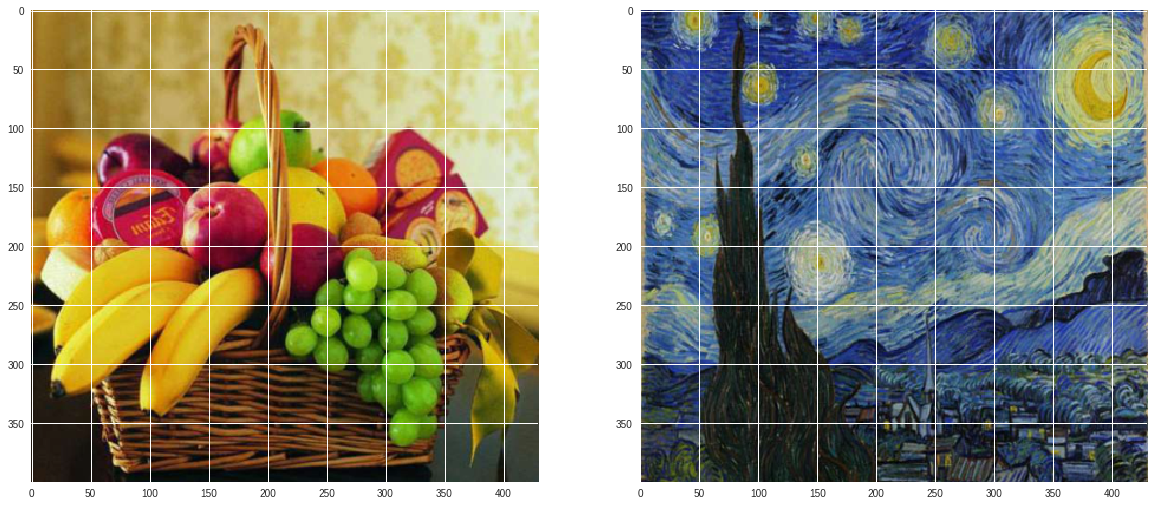

In [13]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20,10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))


In [0]:
def get_features(image,model,layers = None):
  if layers is None:
    layers = { '0':'conv1_1',
               '5':'conv2_1',
               '10':'conv3_1',
               '19':'conv4_1',
               '21':'conv4_2',
               '28':'conv5_1'}
    features ={}
    x = image
    for name, layer in model._modules.items():
      x = layer(x)
      if name in layers:
        features[layers[name]] = x
        
    return features
      

In [0]:
def gram_matrix(tensor):
  _,d,h,w = tensor.size()
  tensor = tensor.view(d,h*w)
  gram = torch.mm(tensor,tensor.t())
  return gram

In [0]:
content_features = get_features(content,vgg)
style_features = get_features(style,vgg)
style_grams = {layer:gram_matrix(style_features[layer]) for layer in style_features}
target = content.clone().requires_grad_(True).to(device)

In [0]:
style_weights = {'conv1_1' : 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}
content_weight = 1
style_weight = 1e6

Total loss:  35074888.0


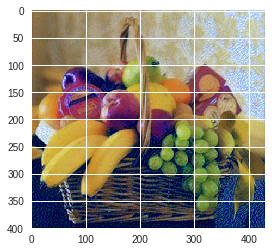

Total loss:  5668141.0


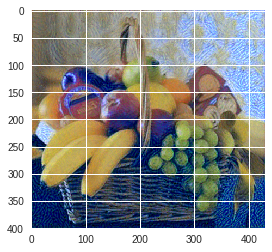

Total loss:  2469154.0


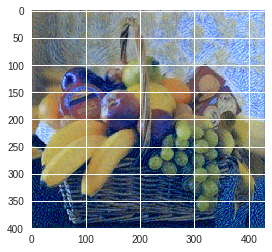

Total loss:  1445822.875


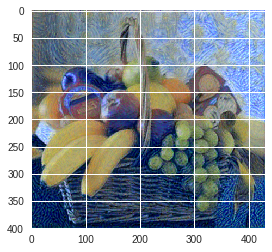

Total loss:  948627.6875


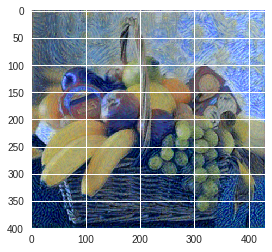

In [19]:
show_every  =400
optimizer = optim.Adam([target],lr=0.003)
steps = 2000

for ii in range(1, steps+1):
  target_features = get_features(target,vgg)
  content_loss = torch.mean((target_features['conv4_2'] -content_features['conv4_2'])**2)
  style_loss = 0
  for layer in style_weights:
    target_feature = target_features[layer]
    target_gram    = gram_matrix(target_feature)
    _,d,h,w = target_feature.shape
    style_gram = style_grams[layer]
    layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
    style_loss+= layer_style_loss/(d*h*w)
    
  total_loss = content_weight * content_loss + style_weight * style_loss
  optimizer.zero_grad()
  total_loss.backward()
  optimizer.step()
  
  if ii % show_every ==0:
    print('Total loss: ',total_loss.item())
    plt.imshow(im_convert(target))
    plt.show()

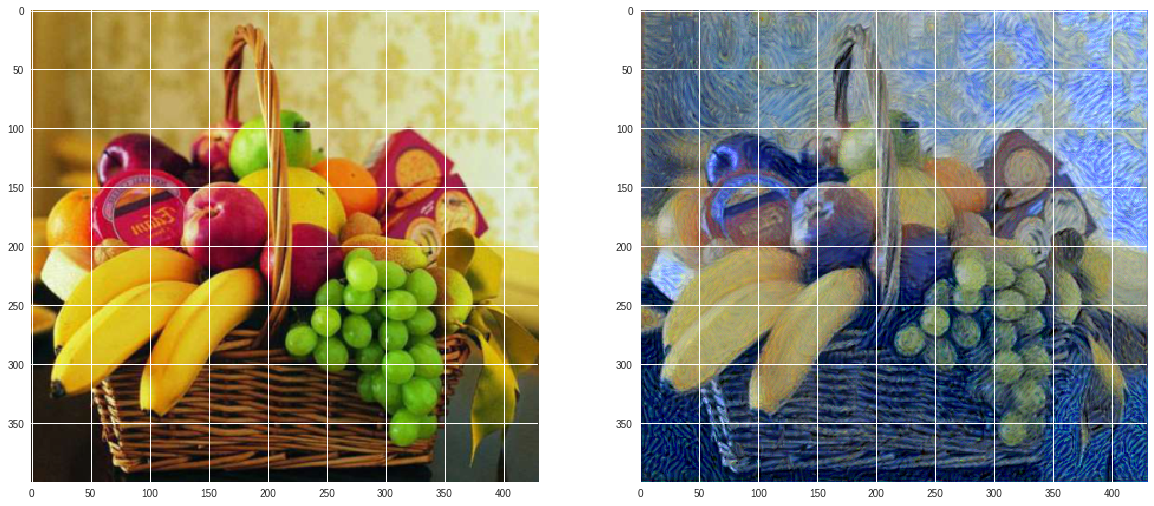

In [20]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20,10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(target))
